## **My Transfer Learning Coding**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np

#data set path in my google drive
dir_path = '/content/drive/My Drive/Dataset1'
categories = ['Barberry','Chinese Redbud','Ginkgo','Oleander','Tangerine']

SIZE = 256

dataset = []

### read the leaf images from google drive 
### convert them into grayscale iamges
### then resize all images into 224 X 224 

for i in categories:
  count = 0 
  path= dir_path+'/train/'+ i
  for img in os.listdir(path):
      img_array =  cv2.imread(os.path.join(path,img))
      new_array = cv2.resize(img_array , (SIZE,SIZE))
      dataset.append([new_array ,i])
      count+=1
  print("\n no of "+ i + " images : ",count)
    
print("\n total no of  images :",len(dataset))



 no of Barberry images :  54

 no of Chinese Redbud images :  71

 no of Ginkgo images :  61

 no of Oleander images :  65

 no of Tangerine images :  55

 total no of  images : 306


In [ ]:
#create 2 empty lists such as x and y for features and labels 

x=[]
y=[]

for features , label in dataset:
    x.append(features)
    y.append(label)

#reshape the features map into common shape

x=np.array(x).reshape(-1,SIZE,SIZE,3)

#divide the x array elements by 255

x = np.array(x)/255.0


print(x[0].shape)


print(x.shape[0], 'train samples')

(256, 256, 3)
306 train samples


In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le = LabelEncoder()
y = le.fit_transform(y)
print(y[0])
####   One Hot Encode the Numerical Values
y = np_utils.to_categorical(y, 5)
print(y[0])


Using TensorFlow backend.


0
[1. 0. 0. 0. 0.]


In [ ]:
### import train_test_split method to split the dataset into train and test randomly
from sklearn.model_selection import train_test_split

(trainData , testData , trainLabels , testLabels) = train_test_split(x ,y, test_size = 0.3 ,random_state = 42)

print(len(trainData))
print(len(testData))

214
92


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_data_gen = ImageDataGenerator(
    rotation_range = 40 ,
    shear_range=0.2 ,
    zoom_range = 0.2,
    horizontal_flip=True,
    fill_mode = 'nearest'
    )

train_data_gen.fit(trainData)

In [ ]:
import keras
from keras.models import Model
from keras.layers import Input,Dense,Flatten
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array , load_img
import argparse

vgg_model = VGG16(weights='imagenet',include_top=False)

vgg_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
model_weights_file = 'vgg-16-weights-file.h5'

for layer in vgg_model.layers:
  layer.trainable = False

In [ ]:
input = Input(shape = (SIZE,SIZE,3))
output_vgg_16_conv = vgg_model(input)
x = Flatten()(output_vgg_16_conv)
x = Dense(124, activation='relu')(x)
x = Dense(86, activation='relu')(x)
x = Dense(5, activation='softmax')(x)

model = Model(input=input ,output = x)

model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 124)               4063356   
_________________________________________________________________
dense_2 (Dense)              (None, 86)                10750     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 435       
Total params: 18,789,229
Trainable params: 4,074,541
Non-trainable params: 14,714,688
_______________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [ ]:
model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("transfer_img_aug_cnn_vgg_16.h5",
                             monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')


In [ ]:
history = model.fit_generator(train_data_gen.flow(trainData, trainLabels),
                    validation_data =(testData,testLabels),
                    epochs=10,
                    verbose=1,
                    callbacks=[checkpoint])

Epoch 1/10
7/7 [==============================] - 8s 1s/step - loss: 2.6627 - accuracy: 0.2617 - val_loss: 0.6263 - val_accuracy: 0.6848

Epoch 00001: val_loss improved from inf to 0.62629, saving model to transfer_img_aug_cnn_vgg_16.h5
Epoch 2/10
7/7 [==============================] - 4s 537ms/step - loss: 0.3927 - accuracy: 0.8318 - val_loss: 0.0436 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.62629 to 0.04358, saving model to transfer_img_aug_cnn_vgg_16.h5
Epoch 3/10
7/7 [==============================] - 3s 401ms/step - loss: 0.0642 - accuracy: 0.9860 - val_loss: 0.0223 - val_accuracy: 0.9891

Epoch 00003: val_loss improved from 0.04358 to 0.02226, saving model to transfer_img_aug_cnn_vgg_16.h5
Epoch 4/10
7/7 [==============================] - 4s 509ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.0121 - val_accuracy: 0.9891

Epoch 00004: val_loss improved from 0.02226 to 0.01205, saving model to transfer_img_aug_cnn_vgg_16.h5
Epoch 5/10
7/7 [===============

In [ ]:
# load weights into new model
"""model.load_weights("transfer_img_aug_cnn_vgg_16.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])"""

eval = model.evaluate(testData,testLabels)

print(" Loss = {:.10f}     Accuracy = {:.10f}% ".format(eval[0],eval[1]*100))

92/92 [==============================] - 1s 8ms/step
 Loss = 0.0015416792     Accuracy = 100.0000000000% 


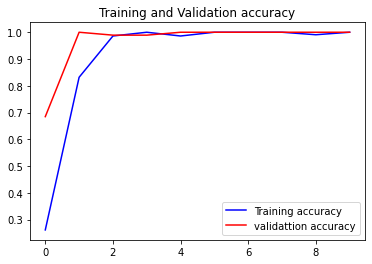

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs , acc , 'b' , label = 'Training accuracy')
plt.plot(epochs , val_acc , 'r' , label = 'validattion accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

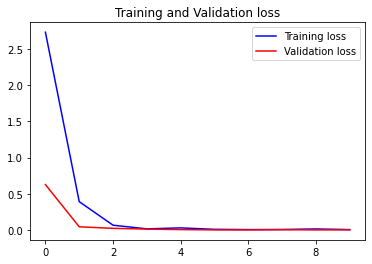

In [ ]:
plt.plot(epochs , loss , 'b' , label = 'Training loss')
plt.plot(epochs , val_loss , 'r' , label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


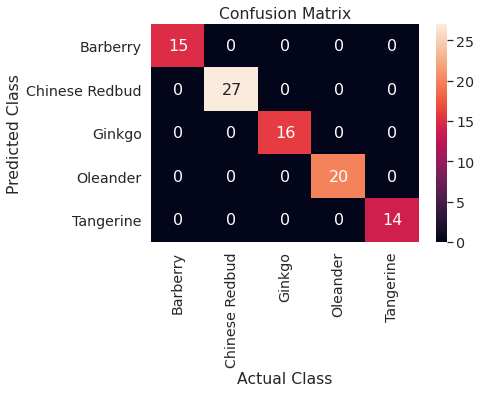

In [ ]:
### plot the confusion matrix and classification report
import seaborn as sn
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix

predictions = model.predict(testData)

y_pred = (predictions > 0.5)
matrix = confusion_matrix(testLabels.argmax(axis=1), y_pred.argmax(axis=1))

df_cm = pd.DataFrame(matrix,index= categories, columns=categories)
sn.set(font_scale=1.3) # for label size
plt.title(" Confusion Matrix ")
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')
plt.show()

In [ ]:
print('\n\n\n Classification Report \n\n')
print(classification_report(testLabels, y_pred, target_names=categories))




 Classification Report 


                precision    recall  f1-score   support

      Barberry       1.00      1.00      1.00        15
Chinese Redbud       1.00      1.00      1.00        27
        Ginkgo       1.00      1.00      1.00        16
      Oleander       1.00      1.00      1.00        20
     Tangerine       1.00      1.00      1.00        14

     micro avg       1.00      1.00      1.00        92
     macro avg       1.00      1.00      1.00        92
  weighted avg       1.00      1.00      1.00        92
   samples avg       1.00      1.00      1.00        92



Saving t8.jpg to t8.jpg
Saving t3.jpg to t3.jpg
Saving test 1.jpg to test 1.jpg


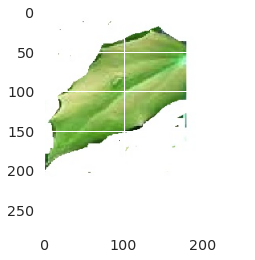

(256, 256, 3) 


(1, 256, 256, 3) 



 Name of the leaf is : Barberry


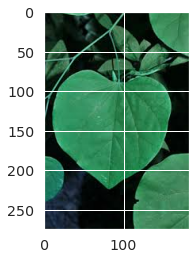

(256, 256, 3) 


(1, 256, 256, 3) 



 Name of the leaf is : Tangerine


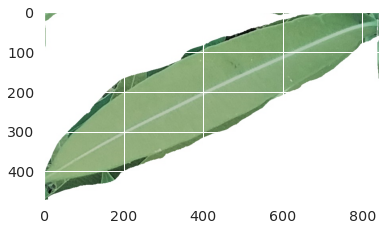

(256, 256, 3) 


(1, 256, 256, 3) 



 Name of the leaf is : Oleander


In [ ]:
#test_path = "/content/drive/My Drive/test 1.jpg"

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  test_path = '/content/'+fn
  image = cv2.imread(test_path)
  plt.imshow(image)
  plt.show()

  test_feature = cv2.resize(image, (SIZE,SIZE))
  print(test_feature.shape ,'\n\n')

  test_feature = test_feature.reshape(-1,test_feature.shape[0],test_feature.shape[1],3)
  print(test_feature.shape ,'\n\n')
  
  test_prediction = model.predict(test_feature)

  predicted_index = np.argmax(test_prediction)

  predicted_class = categories[predicted_index]

  print("\n Name of the leaf is : "+predicted_class)

  #print(test_prediction)
  #print("\n Barberry ={:.10f}%, \n Chinese Redbud ={:.10f}%,\n Ginkgo={:.10f}%, \n Oleander={:.10f}%, \n Tangerine ={:.10f}%".format(test_prediction[0][0]*100, test_prediction[0][1]*100,test_prediction[0][2]*100,test_prediction[0][3]*100,test_prediction[0][4]*100))



In [ ]:
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array,load_img
import keras
from keras import models

layer_outputs = [layer.output for layer in model.layers[2:]] 
# Extracts the outputs of the top 16 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

for layers in model.layers:
  print(layers)
  print('\n')

print("no of layers in model =",len(model.layers))

activations = activation_model.predict(test_feature) 
# Returns a list of five Numpy arrays: one array per layer activation


In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)
print("\n\nFlatten layer\n\n")
plt.matshow(first_layer_activation[:4], cmap='viridis')

In [ ]:
second_layer_activation = activations[1]
print(second_layer_activation.shape)
print("\n\n Fully connected layer 1\n\n")
plt.matshow(second_layer_activation[:4], cmap='viridis')

In [ ]:
third_layer_activation = activations[2]
print(third_layer_activation.shape)
print("\n\nFully Connected layer 2\n\n")
plt.matshow(third_layer_activation[:4], cmap='viridis')

In [ ]:
fourth_layer_activation = activations[3]
print(fourth_layer_activation.shape)
print("\n\nClassification layer \n\n")
plt.matshow(fourth_layer_activation[:4], cmap='viridis')